In [1]:
import os
import jams
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import time
from scipy.io import wavfile

In [2]:
def audio_CQT(file_num, start, dur):  # start and dur in seconds

    # Load audio and define paths
    path = r'D:/Projects/UniBo-Projects/SistemiDigitali-Projects/tab-writer/GuitarSet Zenodo/version-110/audio_hex-pickup_debleeded'
    audio_file = os.listdir(path)
    audio_path = os.path.join(path, audio_file[file_num])

    # Function for removing noise
    def cqt_lim(CQT):
        new_CQT = np.copy(CQT)
        new_CQT[new_CQT < -60] = -120
        return new_CQT

    # Perform the Constant-Q Transform
    #data, sr = librosa.load(audio_path, sr = None, mono = True, offset = start, duration = dur)
    data, sr = librosa.load(audio_path, sr = None, mono = True)
    CQT = librosa.cqt(data, sr = 44100, hop_length = 1024, fmin = None, n_bins = 96, bins_per_octave = 12)
    CQT_mag = librosa.magphase(CQT)[0]**4
    CQTdB = librosa.core.amplitude_to_db(CQT_mag, ref = np.amax)
    new_CQT = cqt_lim(CQTdB)

    return new_CQT

In [3]:
def preprocess_audio(file_num):
    
    path = r'D:/Projects/UniBo-Projects/SistemiDigitali-Projects/tab-writer/GuitarSet Zenodo/version-110/audio_mono-mic'
    audio_file = os.listdir(path)
    audio_path = os.path.join(path, audio_file[file_num])
    
    sr_original, data = wavfile.read(audio_path)
    
    
    data = data.astype(float)
    
    data = librosa.util.normalize(data)
    data = librosa.resample(data, sr_original, 22050)
    
    data = np.abs(librosa.cqt(data,
                              hop_length=512, 
                              sr=22050, 
                              n_bins=192, 
                              bins_per_octave=24))
        
    return data

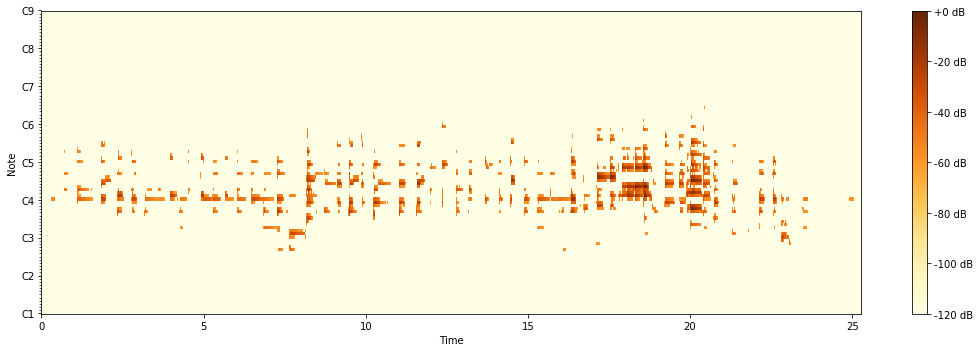

[0.00000000e+00 2.32199546e-02 4.64399093e-02 ... 2.51936508e+01
 2.52168707e+01 2.52400907e+01]


In [4]:
new_CQT = audio_CQT(12,2.32199546e-02,4.64399093e-02-2.32199546e-02)

plt.figure(figsize=(15,5))

librosa.display.specshow(new_CQT, cmap='YlOrBr', fmin=librosa.note_to_hz('C1'), x_axis='time', y_axis='cqt_note')
#librosa.display.specshow(new_CQT, cmap='gray_r', fmin=librosa.note_to_hz('C1'), x_axis='time', y_axis='cqt_note')

#plt.xlim(0, 0.2)
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

frame_indices = list(range(len(np.swapaxes(new_CQT, 0, 1))))
times = librosa.frames_to_time(frame_indices, sr = 44100, hop_length=1024)
print(times)

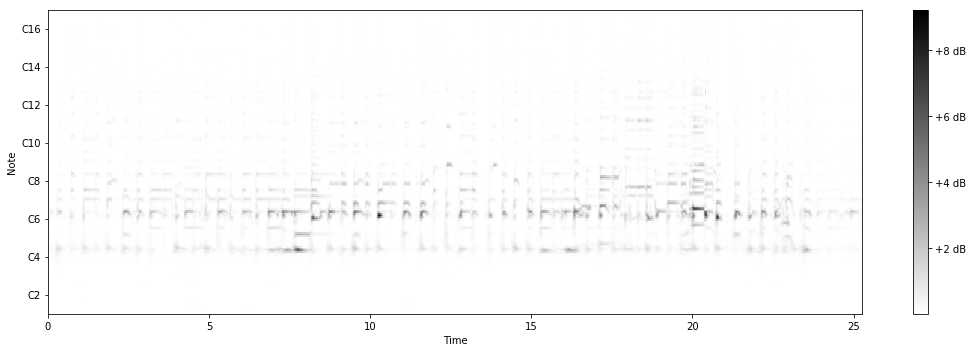

[0.         0.02321995 0.04643991 0.06965986 0.09287982 0.11609977
 0.13931973 0.16253968 0.18575964 0.20897959 0.23219955 0.2554195
 0.27863946 0.30185941 0.32507937 0.34829932 0.37151927 0.39473923
 0.41795918 0.44117914 0.46439909 0.48761905 0.510839   0.53405896
 0.55727891 0.58049887 0.60371882 0.62693878 0.65015873 0.67337868
 0.69659864 0.71981859 0.74303855 0.7662585  0.78947846 0.81269841
 0.83591837 0.85913832 0.88235828 0.90557823 0.92879819 0.95201814
 0.9752381  0.99845805 1.021678   1.04489796 1.06811791 1.09133787
 1.11455782 1.13777778 1.16099773 1.18421769 1.20743764 1.2306576
 1.25387755 1.27709751 1.30031746 1.32353741 1.34675737 1.36997732
 1.39319728 1.41641723 1.43963719 1.46285714 1.4860771  1.50929705
 1.53251701 1.55573696 1.57895692 1.60217687 1.62539683 1.64861678
 1.67183673 1.69505669 1.71827664 1.7414966  1.76471655 1.78793651
 1.81115646 1.83437642 1.85759637 1.88081633 1.90403628 1.92725624
 1.95047619 1.97369615 1.9969161  2.02013605 2.04335601 2.066575

In [5]:
#new_CQT = audio_CQT(13,2.32199546e-02,4.64399093e-02-2.32199546e-02)
new_CQT = preprocess_audio(12)

plt.figure(figsize=(15,5))

#librosa.display.specshow(new_CQT, cmap='YlOrBr', fmin=librosa.note_to_hz('C1'), x_axis='time', y_axis='cqt_note')
librosa.display.specshow(new_CQT, cmap='gray_r', fmin=librosa.note_to_hz('C1'), x_axis='time', y_axis='cqt_note')

#plt.xlim(0, 0.2)
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

frame_indices = list(range(len(new_CQT)))
times = librosa.frames_to_time(frame_indices, sr = 22050, hop_length=512)
print(times)

For each Constant-Q transform image, there must be a solution so that the network can adjust its guesses. Luckily, the GuitarSet data set contains all the notes played as MIDI values, time each note begins in the recording, and duration of the note for each audio file. Note: The following code snippets were placed in a function such that they could be used for every 0.2 seconds of audio.

First, the unique notes (retrieved as MIDI notes) being played during the 0.2 seconds of audio loaded must be extracted from the jams files.

## UniqueNotes.py

In [33]:
# Initialize variables
cnt_row = -1
cnt_col = 0
cnt_zero = 0
#jam = MIDI_dat <------- (or the variable from which you are accessing the data from)
#jam = []

start = 2.32199546e-02
stop = 4.64399093e-02

path = r'D:/Projects/UniBo-Projects/SistemiDigitali-Projects/tab-writer/GuitarSet Zenodo/version-110/annotation/'
extension = "jams"
excerpt = "00_BN1-147-Gb_comp"

jam = jams.load(path + excerpt + '.jams')

# Initialize variables
cnt_row = -1
cnt_col = 0
cnt_zero = 0

# Grab all relevant MIDI data (available in MIDI_dat)
for i in range(0, len(jam['annotations'])):
    if jam['annotations'][int(i)]['namespace'] == 'note_midi':
        for j in range(0, len(sorted(jam['annotations'][int(i)]['data']))):
            cnt_row = cnt_row + 1
            for k in range(0, len(sorted(jam['annotations'][int(i)]['data'])[int(j)]) - 1):
                if cnt_zero == 0:
                    MIDI_arr = np.zeros((len(sorted(jam['annotations'][int(i)]['data'])), len(sorted(jam['annotations'][int(i)]['data'])[int(j)]) - 1), dtype = np.float32)
                    cnt_zero = cnt_zero + 1
                if cnt_zero > 0:
                    MIDI_arr = np.vstack((MIDI_arr, np.zeros((len(sorted(jam['annotations'][int(i)]['data'])), len(sorted(jam['annotations'][int(i)]['data'])[int(j)]) - 1), dtype = np.float32)))
                    cnt_zero = cnt_zero + 1  # Keep
                if cnt_col > 2:
                    cnt_col = 0
                MIDI_arr[cnt_row, cnt_col] = sorted(jam['annotations'][int(i)]['data'])[int(j)][int(k)]
                cnt_col = cnt_col + 1
MIDI_dat = np.zeros((cnt_row + 1, cnt_col), dtype = np.float32)
cnt_col2 = 0
for n in range(0, cnt_row + 1):
    for m in range(0, cnt_col):
        if cnt_col2 > 2:
            cnt_col2 = 0
        MIDI_dat[n, cnt_col2] = MIDI_arr[n, cnt_col2]
        cnt_col2 = cnt_col2 + 1
        

print(MIDI_dat)   

[[5.5624489e-02 4.2956915e-01 4.1968685e+01]
 [6.6038638e-01 2.0897959e-01 4.1946430e+01]
 [1.0577333e+00 1.3931973e-01 4.1935555e+01]
 ...
 [1.6945761e+01 2.4961451e-01 6.5058891e+01]
 [1.7364264e+01 2.1478458e-01 6.5039909e+01]
 [1.7775080e+01 7.8947848e-01 6.5033371e+01]]


In [34]:
# Return the unique MIDI notes played (available in MIDI_val)
MIDI_dat_dur = np.copy(MIDI_dat)
for r in range(0, len(MIDI_dat[:, 0])):
    MIDI_dat_dur[r, 0] = MIDI_dat[r, 0] + MIDI_dat[r, 1]
tab_1, = np.where(np.logical_and(MIDI_dat[:, 0] >= start, MIDI_dat[:, 0] <= stop))
tab_2, = np.where(np.logical_and(MIDI_dat_dur[:, 0] >= start, MIDI_dat_dur[:, 0] <= stop))
tab_3, = np.where(np.logical_and(np.logical_and(MIDI_dat[:, 0] < start, MIDI_dat_dur[:, 0] > stop), MIDI_dat[:, 1] > int(stop-start)))
if tab_1.size != 0 and tab_2.size == 0 and tab_3.size == 0:
    tab_ind = tab_1
if tab_1.size == 0 and tab_2.size != 0 and tab_3.size == 0:
    tab_ind = tab_2
if tab_1.size == 0 and tab_2.size == 0 and tab_3.size != 0:
        tab_ind = tab_3
if tab_1.size != 0 and tab_2.size != 0 and tab_3.size == 0:
    tab_ind = np.concatenate([tab_1, tab_2])
if tab_1.size != 0 and tab_2.size == 0 and tab_3.size != 0:
    tab_ind = np.concatenate([tab_1, tab_3])
if tab_1.size == 0 and tab_2.size != 0 and tab_3.size != 0:
    tab_ind = np.concatenate([tab_2, tab_3])
if tab_1.size != 0 and tab_2.size != 0 and tab_3.size != 0:
    tab_ind = np.concatenate([tab_1, tab_2, tab_3])
if tab_1.size == 0 and tab_2.size == 0 and tab_3.size == 0:
    tab_ind = []
if len(tab_ind) != 0:
    MIDI_val = np.zeros((len(tab_ind), 1), dtype = np.float32)
    for z in range(0, len(tab_ind)):
        print(MIDI_dat[tab_ind[z]])
        MIDI_val[z, 0] = int(round(MIDI_dat[tab_ind[z], 2]))
elif len(tab_ind) == 0:
    MIDI_val = []
MIDI_val = np.unique(MIDI_val)
if MIDI_val.size >= 6:
    MIDI_val = np.delete(MIDI_val, np.s_[6::])

print(MIDI_val)

[7.5746030e-03 2.2058956e-01 5.3161991e+01]
[53.]


There can only be six possible notes being played at one time (maximum of one notes on each string); therefore, code will often be repeated six times.There can only be six possible notes being played at one time (maximum of one notes on each string); therefore, code will often be repeated six times.

## FretandSol.py

In [35]:
# Initialize variables
f_row = np.full((6, 6), np.inf)  # 6 strings with 1 note per string
f_col = np.full((6, 6), np.inf)

# Initialize variables
Fret = np.zeros((6, 18), dtype = np.int32)
Sol = np.copy(Fret)
fcnt = -1
fcnt2 = 0

# Retrieve all possible notes played
for q in range(0, 6):
    for e in range(0, 18):
        if q == 0:
            Fret[q, e] = 40 + e
        elif q == 1:
            Fret[q, e] = 45 + e
        elif q == 2:
            Fret[q, e] = 50 + e
        elif q == 3:
            Fret[q, e] = 55 + e
        elif q == 4:
            Fret[q, e] = 59 + e
        elif q == 5:
            Fret[q, e] = 64 + e

print(Fret)

[[40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57]
 [45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62]
 [50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67]
 [55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72]
 [59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76]
 [64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81]]


In [36]:
for t in range(0, len(MIDI_val)):
    Fret_played = (Fret == int(MIDI_val[t]))
    fcnt = fcnt + 1
    cng = 0
    for dr in range(0, len(Fret[:, 0])):
        for dc in range(0, len(Fret[0, :])):
            if Fret_played[dr, dc]*1 == 1:
                if cng == 0:
                    fcnt2 = 0
                    cng = cng + 1
                f_row[fcnt, fcnt2] = dr
                f_col[fcnt, fcnt2] = dc
                fcnt2 = fcnt2 + 1
            Fret_played[dr, dc] = Fret_played[dr, dc]*1
            if Fret_played[dr, dc] == 1:
                Sol[dr, dc] = Fret_played[dr, dc]

print(Sol.astype(int))

[[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [9]:
print(f_col)
print(f_row)

[[15. 10.  5.  0. inf inf]
 [13.  8.  3. inf inf inf]
 [14.  9.  5.  0. inf inf]
 [inf inf inf inf inf inf]
 [inf inf inf inf inf inf]
 [inf inf inf inf inf inf]]
[[ 0.  1.  2.  3. inf inf]
 [ 1.  2.  3. inf inf inf]
 [ 2.  3.  4.  5. inf inf]
 [inf inf inf inf inf inf]
 [inf inf inf inf inf inf]
 [inf inf inf inf inf inf]]


First, a matrix (6, 18) of MIDI values which represents the six strings and 18 frets of a guitar is created under variable Fret:

All possible locations of the unique notes retrieved on the guitar were then determined using Fret, where the matrix below shows a possible solution:

All possible solutions for the combination of frets and strings must be determined. The idea of ‘finger economy’ is created — the lowest note of the chord, the root note, is compared to the rest of the notes in the chord where the number of frets (disregarding the string) each note is from the root note is summed to create a ‘finger economy’ number. The solution with the lowest ‘finger economy’ number is chosen as the correct chord shape.

## PossibleSolution.py

In [10]:
# Initialize the 6 possible note solutions (one note per string)
f_sol_0 = np.copy(f_col)
f_sol_1 = np.copy(f_col)
f_sol_2 = np.copy(f_col)
f_sol_3 = np.copy(f_col)
f_sol_4 = np.copy(f_col)
f_sol_5 = np.copy(f_col)
pri_cnt_c, = np.where(np.isfinite(f_col[0, :]))
pri_cnt_r, = np.where(np.isfinite(f_col[:, 0]))
if len(MIDI_val) > 1:
    for pri in range(0, len(pri_cnt_c)):
        for sub_r in range(1, 6):
            for sub_c in range(0, len(f_sol_0[0, :])):
                if pri == 0:
                    f_sol_0[sub_r, sub_c] = abs(f_col[0, pri] - f_col[sub_r, sub_c])
                if pri == 1:
                    f_sol_1[sub_r, sub_c] = abs(f_col[0, pri] - f_col[sub_r, sub_c])
                if pri == 2:
                    f_sol_2[sub_r, sub_c] = abs(f_col[0, pri] - f_col[sub_r, sub_c])
                if pri == 3:
                    f_sol_3[sub_r, sub_c] = abs(f_col[0, pri] - f_col[sub_r, sub_c])
                if pri == 4:
                    f_sol_4[sub_r, sub_c] = abs(f_col[0, pri] - f_col[sub_r, sub_c])
                if pri == 5:
                    f_sol_5[sub_r, sub_c] = abs(f_col[0, pri] - f_col[sub_r, sub_c])
if len(pri_cnt_r) == 0 or len(pri_cnt_c) == 0:
    True_tab = np.copy(np.zeros((6, 18), dtype = np.int32))
else:
    ck_sol_0 = np.zeros((len(pri_cnt_r) - 1, len(pri_cnt_c) - 1), dtype = np.int32)
    sol_ind_0 = np.copy(ck_sol_0)
    ck_sol_1 = np.zeros((len(pri_cnt_r) - 1, len(pri_cnt_c) - 1), dtype = np.int32)
    sol_ind_1 = np.copy(ck_sol_0)
    ck_sol_2 = np.zeros((len(pri_cnt_r) - 1, len(pri_cnt_c) - 1), dtype = np.int32)
    sol_ind_2 = np.copy(ck_sol_0)
    ck_sol_3 = np.zeros((len(pri_cnt_r) - 1, len(pri_cnt_c) - 1), dtype = np.int32)
    sol_ind_3 = np.copy(ck_sol_0)
    ck_sol_4 = np.zeros((len(pri_cnt_r) - 1, len(pri_cnt_c) - 1), dtype = np.int32)
    sol_ind_4 = np.copy(ck_sol_0)
    ck_sol_5 = np.zeros((len(pri_cnt_r) - 1, len(pri_cnt_c) - 1), dtype = np.int32)
    sol_ind_5 = np.copy(ck_sol_0)

    # Replace infinite values with high finite values for each solution
    for ck_sol in range(0, len(pri_cnt_c)):
        for pri_sol_r in range(1, len(pri_cnt_r)):
            for pri_sol_c in range(0, len(pri_cnt_c) - 1):  # Random - 1
                if ck_sol == 0:
                    if np.any(np.isinf(f_sol_0[pri_sol_r, :])):
                        avoid_0 = np.argwhere(np.isinf(f_sol_0[pri_sol_r, :]))
                        f_sol_0[pri_sol_r, avoid_0] = 999
                if ck_sol == 1:
                    if np.any(np.isinf(f_sol_1[pri_sol_r, :])):
                        avoid_1 = np.argwhere(np.isinf(f_sol_1[pri_sol_r, :]))
                        f_sol_1[pri_sol_r, avoid_1] = 999
                    ck_sol_1[0, pri_sol_c] = min(f_sol_1[pri_sol_r, :])
                if ck_sol == 2:
                    if np.any(np.isinf(f_sol_2[pri_sol_r, :])):
                        avoid_2 = np.argwhere(np.isinf(f_sol_2[pri_sol_r, :]))
                        f_sol_2[pri_sol_r, avoid_2] = 999
                    ck_sol_2[0, pri_sol_c] = min(f_sol_2[pri_sol_r, :])
                if ck_sol == 3:
                    if np.any(np.isinf(f_sol_3[pri_sol_r, :])):
                        avoid_3 = np.argwhere(np.isinf(f_sol_3[pri_sol_r, :]))
                        f_sol_3[pri_sol_r, avoid_3] = 999
                    ck_sol_3[0, pri_sol_c] = min(f_sol_3[pri_sol_r, :])
                if ck_sol == 4:
                    if np.any(np.isinf(f_sol_4[pri_sol_r, :])):
                        avoid_4 = np.argwhere(np.isinf(f_sol_4[pri_sol_r, :]))
                        f_sol_4[pri_sol_r, avoid_4] = 999
                    ck_sol_4[0, pri_sol_c] = min(f_sol_4[pri_sol_r, :])
                if ck_sol == 5:
                    if np.any(np.isinf(f_sol_5[pri_sol_r, :])):
                        avoid_5 = np.argwhere(np.isinf(f_sol_5[pri_sol_r, :]))
                        f_sol_5[pri_sol_r, avoid_5] = 999
                    ck_sol_5[0, pri_sol_c] = min(f_sol_5[pri_sol_r, :])

    # Determine "rating" for each solution
    tab_sol_0 = np.argmin(f_sol_0, axis = 1)
    min_sol_0 = np.min(f_sol_0, axis = 1)
    if np.any(np.isinf(min_sol_0[:])):
        rep_0 = np.argwhere(np.isinf(min_sol_0[:]))
        min_sol_0[rep_0] = 0
    tab_sol_1 = np.argmin(f_sol_1, axis = 1)
    min_sol_1 = np.min(f_sol_1, axis = 1)
    if np.any(np.isinf(min_sol_1[:])):
        rep_1 = np.argwhere(np.isinf(min_sol_1[:]))
        min_sol_1[rep_1] = 0
    tab_sol_2 = np.argmin(f_sol_2, axis = 1)
    min_sol_2 = np.min(f_sol_2, axis = 1)
    if np.any(np.isinf(min_sol_2[:])):
        rep_2 = np.argwhere(np.isinf(min_sol_2[:]))
        min_sol_2[rep_2] = 0
    tab_sol_3 = np.argmin(f_sol_3, axis = 1)
    min_sol_3 = np.min(f_sol_3, axis = 1)
    if np.any(np.isinf(min_sol_3[:])):
        rep_3 = np.argwhere(np.isinf(min_sol_3[:]))
        min_sol_3[rep_3] = 0
    tab_sol_4 = np.argmin(f_sol_4, axis = 1)
    min_sol_4 = np.min(f_sol_4, axis = 1)
    if np.any(np.isinf(min_sol_4[:])):
        rep_4 = np.argwhere(np.isinf(min_sol_4[:]))
        min_sol_4[rep_4] = 0
    tab_sol_5 = np.argmin(f_sol_5, axis = 1)
    min_sol_5 = np.min(f_sol_5, axis = 1)
    if np.any(np.isinf(min_sol_5[:])):
        rep_5 = np.argwhere(np.isinf(min_sol_5[:]))
        min_sol_5[rep_5] = 0
    sol_0 = np.sum(min_sol_0[:])
    sol_1 = np.sum(min_sol_1[:])
    sol_2 = np.sum(min_sol_2[:])
    sol_3 = np.sum(min_sol_3[:])
    sol_4 = np.sum(min_sol_4[:])
    sol_5 = np.sum(min_sol_4[:])


Although this method does not always match the correct version of the chord being played in the recording, it does not negatively affect performance of the CNN as a C major chord played in the open position does not differ than C major played on the 8th fret.
The final solution is subsequently chosen using a combination of the strings and frets arrays in the final solution:

## FinalSolution.py

In [11]:
# Initalize variables
acc_sol = False
idx_pass = False

# Choose best solution based on previous rating
if len(pri_cnt_c) == 1:
    fin_sol_arr = sol_0
if len(pri_cnt_c) == 2:
    fin_sol_arr = np.append(sol_0, sol_1)
if len(pri_cnt_c) == 3:
    fin_sol_arr = np.append(np.append(sol_0, sol_1), sol_2)
if len(pri_cnt_c) == 4:
    fin_sol_arr = np.append(np.append(sol_0, sol_1), np.append(sol_2, sol_3))
if len(pri_cnt_c) == 5:
    fin_sol_arr = np.array(np.append(np.append(sol_0, sol_1), np.append(sol_2, sol_3)), sol_4)
if len(pri_cnt_c) == 6:
    fin_sol_arr = np.array(np.append(np.append(sol_0, sol_1), np.append(sol_2, sol_3)), np.append(sol_4, sol_5))
fin_choice = np.argmin(fin_sol_arr)
response, ret_cnts, ret_idx = np.unique(fin_sol_arr, return_counts = True, return_index = True)
ret_idx = [np.argwhere(idx_cnt == fin_sol_arr) for idx_cnt in np.unique(fin_sol_arr)]
for idx_cnt_row in range(0, len(ret_idx)):
    if np.amin(response) == np.amin(fin_sol_arr) and len(ret_idx[idx_cnt_row]) > 2:
        fin_sol_arr = np.delete(fin_sol_arr, np.argwhere(np.amin(fin_sol_arr)))
if np.amin(response) == np.amin(fin_sol_arr) and ret_cnts[np.argwhere(np.amin(fin_sol_arr))] > 2:
    fin_sol_arr = np.delete(fin_sol_arr, np.argwhere(np.amin(fin_sol_arr)))
    fin_choice = np.argmin(fin_sol_arr)

# Choose solution and choose the next best solution if there are two notes on one string
while acc_sol == False:
    fin_tab_row = np.zeros((len(pri_cnt_r)), dtype = np.int32)
    fin_tab_col = np.zeros((len(pri_cnt_r)), dtype = np.int32)
    if fin_choice == 0:
        fin_tab_row[0] = f_row[0, 0]
        fin_tab_col[0] = f_col[0, 0]
        for counter in range(1, len(pri_cnt_r)):
            fin_tab_row[counter] = f_row[counter, tab_sol_0[counter]]
            fin_tab_col[counter] = f_col[counter, tab_sol_0[counter]]
    if fin_choice == 1:
        fin_tab_row[0] = f_row[0, 1]
        fin_tab_col[0] = f_col[0, 1]
        for counter in range(1, len(pri_cnt_r)):
            fin_tab_row[counter] = f_row[counter, tab_sol_1[counter]]
            fin_tab_col[counter] = f_col[counter, tab_sol_1[counter]]
    if fin_choice == 2:
        fin_tab_row[0] = f_row[0, 2]
        fin_tab_col[0] = f_col[0, 2]
        for counter in range(1, len(pri_cnt_r)):
            fin_tab_row[counter] = f_row[counter, tab_sol_2[counter]]
            fin_tab_col[counter] = f_col[counter, tab_sol_2[counter]]
    if fin_choice == 3:
        fin_tab_row[0] = f_row[0, 3]
        fin_tab_col[0] = f_col[0, 3]
        for counter in range(1, len(pri_cnt_r)):
            fin_tab_row[counter] = f_row[counter, tab_sol_3[counter]]
            fin_tab_col[counter] = f_col[counter, tab_sol_3[counter]]
    if fin_choice == 4:
        fin_tab_row[0] = f_row[0, 4]
        fin_tab_col[0] = f_col[0, 4]
        for counter in range(1, len(pri_cnt_r)):
            fin_tab_row[counter] = f_row[counter, tab_sol_4[counter]]
            fin_tab_col[counter] = f_col[counter, tab_sol_4[counter]]
    if fin_choice == 5:
        fin_tab_row[0] = f_row[0, 5]
        fin_tab_col[0] = f_col[0, 5]
        for counter in range(1, len(pri_cnt_r)):
            fin_tab_row[counter] = f_row[counter, tab_sol_5[counter]]
            fin_tab_col[counter] = f_col[counter, tab_sol_5[counter]]
    acc_sol = True
    idx_cnt = [np.argwhere(uni_cnt == fin_tab_row) for uni_cnt in np.unique(fin_tab_row)]
    max_len_cnt = np.zeros((len(idx_cnt)), dtype = np.int32)
    for str_cnt_row in range(0, len(idx_cnt)):
        if len(idx_cnt[str_cnt_row]) > 1:
            fin_sol_arr = fin_sol_arr.astype('int64')
            if fin_sol_arr.size > 1:
                fin_sol_arr = np.delete(fin_sol_arr, fin_choice)
                idx_pass = True
                acc_sol = False
                break
            else:
                continue
    fin_choice = np.argmin(fin_sol_arr)
fin_tab_row = abs(fin_tab_row - 5)

# Return the final tab
True_tab = np.copy(np.zeros((6, 18), dtype = np.int32))
for tt_cnt in range(0, len(fin_tab_col)):
    True_tab[fin_tab_row[tt_cnt], fin_tab_col[tt_cnt]] = 1

Additionally, in the first column for each row, if there exists a note (1 in the row), a zero is appended and vice versa if a note does not exist. This is done so the softmax function can still choose a category for strings without a note being played.
The previous code snippets return data such that the output is similar to a one-hot encoding of categories, the following matrix format was returned for each 0.2 seconds of audio:

The above matrix is the guitar tab solution for one random 0.2 second selection from the GuitarSet data set. Each matrix shape is (6, 19) where the six rows correspond to each guitar string (eBGDAE from top to bottom). The first column identifies whether that the string is not being played, the second column identifies if the open string is being played, and the third through nineteenth columns identify the specific fret that is being played starting from the first fret. When training, this matrix is broken up into six separate arrays to train each head of the model.

In [12]:
print(True_tab)

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [13]:
True_tab2 = np.c_[np.zeros(6, dtype = np.int32), True_tab]

value = 1

for i in range(6):
    if value not in True_tab2[i, :]:
        True_tab2[i, 0] = 1
    
print(True_tab2)

[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
